In [12]:
import numpy as np
import matplotlib.pyplot as plt
import lcdata
import os
import sys
from tqdm import tqdm
from astropy.table import vstack, Table
import pandas as pd
import random
from typing import Optional, Tuple
import multiprocessing

In [13]:
#filepaths where new data (as lcdata) are located
data_2021 = '/global/cfs/cdirs/m4237/desirt/2021_data/lcdata/'
DCDE_data = '/global/cfs/cdirs/m4237/desirt/new_data/DCDE/'
DCDE2_data = '/global/cfs/cdirs/m4237/desirt/new_data/DCDE2/'
DCDE3_data = '/global/cfs/cdirs/m4237/desirt/new_data/DCDE3/'
DCDE4_data = '/global/cfs/cdirs/m4237/desirt/new_data/DCDE4/'

In [14]:
filelist = [data_2021, DCDE_data, DCDE2_data, DCDE3_data, DCDE4_data]

In [15]:
def band_info(filepath, band):
    '''
    For a given observational band, gets magnitudes, error in magnitude, and files that might have problems. 
    ---
    Inputs:
    ---
    filepath (string): Path to the lcdata hdf5 files to get data from.
    band (string): Band getting info for. options are 'g', 'r', and 'z', but theoretically could input any band.
    ---
    Outputs:
    ---
    bandmags (np.array): Array of all magnitudes in that band.
    bandmagerrs (np.array): Array of all magnitude errors in that band.
    problem_files (list): List of any files flagged as a problem. This includes ones with unusually/extremely high fluxes and files couldn't get any data from. 
    '''
    bandfluxes = []
    bandsigmaf = []
    problem_files = []
    string = f'lsst{band}'

    for file in os.listdir(filepath):
        if file.endswith('.hdf5'):
            try:
                #try to find the file, read in its light curves, and get its flux and fluxerr
                string_file = os.path.join(filepath, file)
                dataset = lcdata.read_hdf5(string_file)
                dataset_size = len(dataset.light_curves)
                
                for i in range(dataset_size):
                    data = dataset.light_curves[i]
                    bandcol = data[data['band'] == string]
                    band_fluxes = bandcol['flux']
                    band_flux_errors = bandcol['fluxerr']
                    bandfluxes.extend(band_fluxes)
                    bandsigmaf.extend(band_flux_errors)
                    
                    #if unusually high flux in the data flag as potential problem file
                    if np.any(band_fluxes >= 4e6):
                        problem_files.append(f'{filepath}{file}')
                        
            #if can't get data from the file add it as a problem file
            except:
                problem_files.append(file)
    
    #convert to array then convert to magnitude
    bandfluxes = np.array(bandfluxes)
    bandsigmaf = np.array(bandsigmaf)
    bandmags = 22.5 - 2.5 * np.log10(bandfluxes)
    bandmagerrs = bandsigmaf/(bandfluxes * (np.log(10)/2.5))
    
    #mask out negative magnitudes (there shouldn't be any) 
    mask = bandmags >= 0
    bandmags = bandmags[mask]
    bandmagerrs = bandmagerrs[mask]
    
    return bandmags, bandmagerrs, problem_files

In [16]:
import os
import numpy as np
from tqdm import tqdm
import lcdata

def get_cadences(file_path, band=None, progressbar=False):
    '''
    For a given observational band (or for all data), determines cadences. 
    ---
    Inputs:
    ---
    file_path (string): Path to the lcdata hdf5 files to get data from.
    band (string, optional): Band getting info for. If no band, will find all cadences. options are 'g', 'r', and 'z', but theoretically could input any band.
    progressbar (boolean): Whether or not to display a progress bar. 
    ---
    Outputs:
    ---
    np.array(delta_ts) (np.array): Array of cadences. 
    '''
    delta_ts = []
    file_list = [file for file in os.listdir(file_path) if file.endswith('.hdf5')]
    total_files = len(file_list)

    if band is not None:
        band = f'lsst{band}'

    # look for cadences, have progressbar if progressbar = True
    with tqdm(total=total_files, desc='Progress', unit='file', disable=not progressbar) as pbar:
        for file in file_list:
            try:
                filepath = os.path.join(file_path, file)
                for data in lcdata.read_hdf5(filepath).light_curves:
                    if band is None or (data['band'] == band).any():
                        mask = data['band'] == band
                        delta_t = np.diff(data['time'][mask])
                        delta_ts.extend(delta_t)
                pbar.set_postfix({'Processed': len(delta_ts)})
                pbar.update(1)
            #if had trouble reading file print the exception
            except Exception as e:
                print(f'Error processing {file}: {e}')

    return np.array(delta_ts)


In [17]:
def process_band(filelist, band):
    '''
    For a given observational band, determines magnitudes, magnitude errors, and cadences, returned as a dataframe. 
    ---
    Inputs:
    ---
    filelist (list): List of paths to lcdata hdf5 files to get data from.
    band (string): Band getting info for. options are 'g', 'r', and 'z', but theoretically could input any band.
    ---
    Outputs:
    ---
    df (pandas.DataFrame): Dataframe with all magnitudes and magnitude errors for given band. 
    all_cadences (np.array): Array with all cadences for given band.
    problem_files (list): List of files flagged as having a problem by band_info function. 
    '''
    all_mags = []
    all_magerrs = []
    problem_files = []
    all_cadences = []

    #have a progress bar for the files in the filelist
    with tqdm(total=len(filelist), desc=f'Processing band {band}') as pbar:
        for file in filelist:
            try:
                #get mag magerrs and cadences
                mags, magerrs, band_problem_files = band_info(file, band)
                cadences = get_cadences(file, band)
                #this could probably be more efficient, but just appending/extending lists with results
                all_mags.append(mags)
                all_magerrs.append(magerrs)
                all_cadences.append(cadences)
                problem_files.extend(band_problem_files)
                
            #error handling
            except FileNotFoundError:
                print(f'{file} not found')
            except Exception as e:
                print(f'{file} broke on {band}: {str(e)}')

            pbar.update(1)
            
    #combine the lists of arrays into one array
    all_mags = np.concatenate(all_mags)
    all_magerrs = np.concatenate(all_magerrs)
    all_cadences = np.concatenate(all_cadences)
    
    #put info in pandas dataframe
    data = {'mag': all_mags, 'magerr': all_magerrs}
    df = pd.DataFrame(data)
    
    return df, all_cadences, problem_files

In [18]:
#get data for all bands
bands = ['g', 'r', 'z']
all_bands = {band: process_band(filelist, band) for band in bands}

Processing band g:  60%|██████    | 3/5 [01:21<00:53, 26.72s/it]

Error processing A202210060344377m154246.hdf5: index 0 is out of bounds for axis 0 with size 0


Processing band r:  60%|██████    | 3/5 [00:59<00:39, 19.68s/it]

Error processing A202210060344377m154246.hdf5: index 0 is out of bounds for axis 0 with size 0


Processing band z:  60%|██████    | 3/5 [01:19<00:52, 26.21s/it]

Error processing A202210060344377m154246.hdf5: index 0 is out of bounds for axis 0 with size 0


Processing band z: 100%|██████████| 5/5 [02:19<00:00, 27.98s/it]


In [20]:
#name band info. all_*s are the band dataframes
all_gs, obs_cadences_g, g_problem_files = all_bands['g']
all_rs, obs_cadences_r, r_problem_files = all_bands['r']
all_zs, obs_cadences_z, z_problem_files = all_bands['z']

In [21]:
#path to noisy simulation data without any cadence cuts
sims_path = '/global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/nearest_noise/'

In [4]:
# get cadences for simulations, use the progress bar 
sims_cadences_g = get_cadences(sims_path, band='g', progressbar = True)
sims_cadences_r = get_cadences(sims_path, band='r', progressbar = True)
sims_cadences_z = get_cadences(sims_path, band='z', progressbar = True)

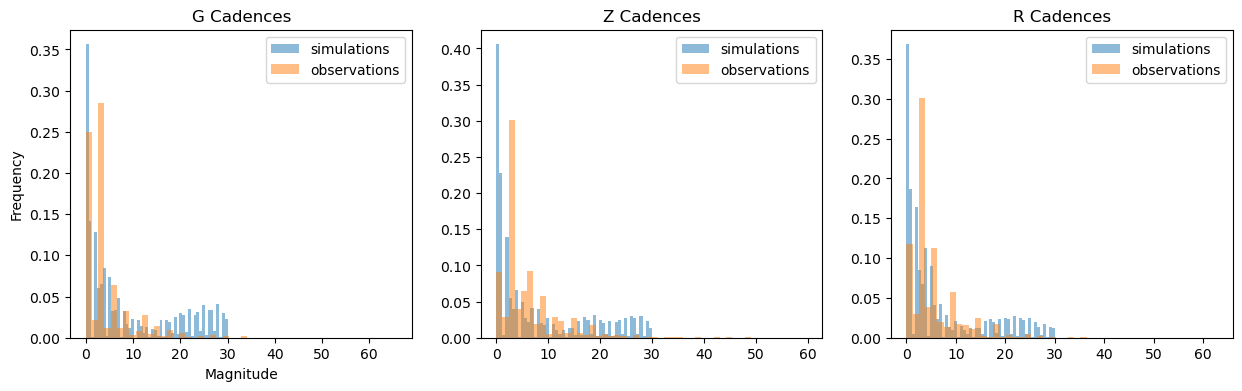

In [29]:
# compare cadences of noisy simulations vs the observations in a histogram 
label1 = 'simulations'
label2 = 'observations'
fig, ax = plt.subplots(1, 3, figsize = (15, 4))

ax[0].hist(sims_cadences_g, bins=50, alpha=0.5, range=[0, 30], label=label1, density=True)
ax[0].hist(obs_cadences_g, bins=50, alpha=0.5, label=label2, density=True)
ax[0].set_title('G Cadences')
ax[0].set_xlabel('Magnitude')
ax[0].set_ylabel('Frequency')
ax[0].legend()


ax[1].hist(sims_cadences_z, bins=50, alpha=0.5, range=[0, 30], label=label1, density=True)
ax[1].hist(obs_cadences_z, bins=50, alpha=0.5, label=label2, density=True)
ax[1].set_title('Z Cadences')
ax[1].legend()

ax[2].hist(sims_cadences_r, bins=50, alpha=0.5, range=[0, 30], label=label1, density=True)
ax[2].hist(obs_cadences_r, bins=50, alpha=0.5, label=label2, density=True)
ax[2].set_title('R Cadences')
ax[2].legend()

In [11]:
#this cell is for cutting simulation data
def compute_cadence_indices(time_array):
    '''
    Computes cadences, then gets indices with a cadence of less than or equal to 1 when compared to the next index. Should be done by band. 
    ---
    Inputs:
    ---
    time_array (np.array): Array of times to get cadences for. 
    ---
    Outputs:
    ---
    np.where(time_diff <= 1)[0] (np.ndarray): Indices of elements in time_diff where cadence is less than or equal to 1. 
    '''
    time_diff = np.diff(time_array)
    return np.where(time_diff <= 1)[0]

def cut_simulation_dataset(model_name, lightcurve_path=sims_path, cut_cadence = True, 
                           output_dir='/global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts/', min_detections: int = 1, 
                           cadence_probs: Optional[Tuple[float, float, float]] = (0.5, 0.4, 0.4)):
    '''
    Cuts simulation dataset for cadence and/or minimum detections, then saves new cut dataset to an output lcdata file. 
    ---
    Inputs:
    ---
    model_name (string): Name of model to cut.
    lightcurve_path (string): Source of noisy data to cut (path)
    cut_cadence (boolean): Whether or not to cut by cadence. Default is True
    output_dir (string): Path to directory to save cut data to. The file will be saved there as {model_name}.hdf5, and automatically overwrites, so be cautious. 
    min_detections (int): Minimum detections to save a light curve. Default is 1 so no empty light curves will be saved. Might be repetitive if noise function
                        already does a non-detection cut. 
    cadence_probs(Tuple[float, float, float]): Probability of cutting a given band cadence; ie if 0.5, will cut approximately 50% of observations with a cadence
                        of one or less. Order is g, r, z
    '''
    #make sure put in 3 cadence probabilities
    assert len(cadence_probs) == 3, "cadence_probs must contain three probabilities, one each for g, r, and z bands."
    
    #read in data
    dataset = lcdata.read_hdf5(os.path.join(lightcurve_path, f'{model_name}_noisy.hdf5'))
    new_lcs = []
    
    #numbers to count how many points in all of the lightcurves
    have_originally = 0.
    have_after = 0.

    # perform cuts
    for data, metadata in zip(dataset.light_curves, dataset.meta):
            have_originally += len(data)
            
            #cadence cuts
            if cut_cadence:
                #filter by band
                gdata = data[data['band'] == 'lsstg']
                rdata = data[data['band'] == 'lsstr']
                zdata = data[data['band'] == 'lsstz']
                
                #get indices where cadence <= 1
                gindices = compute_cadence_indices(gdata['time'])
                rindices = compute_cadence_indices(rdata['time'])
                zindices = compute_cadence_indices(zdata['time'])

                #get a boolean array the size of the index that has cadence probability of returning true (true means will cut point)
                cut_cadence_g = np.random.choice([False, True], size=len(gindices), p=[1 - cadence_probs[0], cadence_probs[0]])
                cut_cadence_r = np.random.choice([False, True], size=len(rindices), p=[1 - cadence_probs[1], cadence_probs[1]])
                cut_cadence_z = np.random.choice([False, True], size=len(zindices), p=[1 - cadence_probs[2], cadence_probs[2]])

                #get indices where true
                gindices = gindices[~cut_cadence_g]
                rindices = rindices[~cut_cadence_r]
                zindices = zindices[~cut_cadence_z]

                #return only indices where not true (aka cut around cadence probability percent of points with cadence <= 1)
                gnew = np.setdiff1d(np.arange(len(gdata)), gindices)
                rnew = np.setdiff1d(np.arange(len(rdata)), rindices)
                znew = np.setdiff1d(np.arange(len(zdata)), zindices)
                
                #filter
                zdata = zdata[znew]
                gdata = gdata[gnew]
                rdata = rdata[rnew]

                #recombine data that was sorted by band
                data_new = vstack([zdata, rdata, gdata])
            
            else:
                #don't cut by cadence
                data = data_new

            #make sure no problematic datapoints
            if len(data_new[data_new['fluxerr'] == 0]) != 0:
                data_new = data_new[data_new['fluxerr'] != 0]
                # print(f'had a 0 fluxerr for {model_name}')
            
            if len(data_new[data_new['flux'] == 0]) != 0:
                data_new = data_new[data_new['flux'] != 0]
                # print(f'had a 0 fluxerr for {model_name}')
                
            if len(data_new[np.isfinite(data_new['fluxerr'])]) !=  len(data_new):
                data_new = data_new[np.isfinite(data_new['fluxerr'])]
                #print(f'had a nonfinite fluxerr for {model_name}')
                
            if len(data_new[np.isfinite(data_new['flux'])]) !=  len(data_new):
                data_new = data_new[np.isfinite(data_new['flux'])]
                #print(f'had a nonfinite flux for {model_name}')

            #cut nondetections and save viable light curves to the list of light curves
            if len(data_new) >= min_detections:
                have_after += len(data_new)
                light_curve = Table({
                    'time': list(data_new['time']),
                    'flux': list(data_new['flux']),
                    'fluxerr': list(data_new['fluxerr']),
                    'band': list(data_new['band']),
                })

                light_curve.meta = {
                    'object_id': metadata['object_id'],
                    'ra': metadata['ra'],
                    'dec': metadata['dec'],
                    'type': metadata['type'],
                    'redshift': metadata['redshift']
                }

                new_lcs.append(light_curve)

    #convert list of light curves to lcdata and save it to output path 
    if len(new_lcs) > 0:
        new_lc = lcdata.from_light_curves(new_lcs)
        output_path = os.path.join(output_dir, f'{model_name}.hdf5')
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        new_lc.write_hdf5(output_path, overwrite=True)
        print(f'Dataset ({len(new_lc)} objects) has been written into {output_path}. Kept {have_after/have_originally:0.3%}')


In [31]:
#just a list of names of all extragalactic models 
obs = ['SNIa-SALT3', 'SNIb+HostXT_V19','SLSN-I+host', 'SNIcBL+HostXT_V19', 'SNIb-Templates', 
       'SNIIb+HostXT_V19', 'KN_K17', 'SNIax', 'TDE', 'SNIIn-MOSFIT', 'SNII-NMF', 'SNIa-91bg', 
       'SLSN-I_no_host', 'SNII-Templates', 'SNIIn+HostXT_V19', 'KN_B19', 'SNII+HostXT_V19', 
       'SNIc-Templates', 'SNIc+HostXT_V19']

In [13]:
#use multiprocessing to cut all the data. might need to specify threads if worried about cpu usage
def process_obs(i):
    cut_simulation_dataset(obs[i])

if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        # create a multiprocessing pool
        
        # use `imap` to get results as they become available
        results = list(tqdm(pool.imap(process_obs, range(len(obs))), total=len(obs), desc='Progress', unit='file'))


Progress:   0%|          | 0/10 [00:00<?, ?file/s]

Dataset (99 objects) has been written into /global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts/KN_B19.hdf5. Kept 60.656%
Dataset (752 objects) has been written into /global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts/SLSN-I_no_host.hdf5. Kept 86.361%
Dataset (409 objects) has been written into /global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts/KN_K17.hdf5. Kept 63.451%


Progress:  10%|█         | 1/10 [00:02<00:23,  2.64s/file]

Dataset (5623 objects) has been written into /global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts/SNIc-Templates.hdf5. Kept 84.270%


Progress:  30%|███       | 3/10 [00:17<00:42,  6.10s/file]

Dataset (9160 objects) has been written into /global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts/SNIIn-MOSFIT.hdf5. Kept 83.866%
Dataset (9697 objects) has been written into /global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts/SNIb-Templates.hdf5. Kept 84.193%


Progress:  40%|████      | 4/10 [00:27<00:46,  7.67s/file]

Dataset (12159 objects) has been written into /global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts/SNIcBL+HostXT_V19.hdf5. Kept 82.909%


Progress:  60%|██████    | 6/10 [00:35<00:22,  5.64s/file]

Dataset (12983 objects) has been written into /global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts/SNIax.hdf5. Kept 84.263%


Progress:  80%|████████  | 8/10 [00:36<00:07,  3.64s/file]

Dataset (15338 objects) has been written into /global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts/SNIa-91bg.hdf5. Kept 82.503%


Progress:  90%|█████████ | 9/10 [00:45<00:04,  4.73s/file]

Dataset (67436 objects) has been written into /global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts/SNIa-SALT3.hdf5. Kept 84.006%


Progress: 100%|██████████| 10/10 [02:59<00:00, 17.92s/file]


In [5]:
def get_magnitudes(file_paths, extension='.hdf5', band = None, zeropoint=22.5, type_object='unknown'):
    '''
    Converts fluxes to magnitudes and saves all magnitudes from the given set of objects to an array. Meant to be used to retrieve magnitudes for making histograms. 
    ---
    Inputs:
    ---
    file_paths (string): Path to the lcdata hdf5 files to get magnitudes from.
    extension (string): Filetype to look for. Generally will be .hdf5 since that is what lcdata is saved as
    zeropoint (float): Zeropoint magnitude used in conversion of flux to mag.
    type_object (string): Type of object to get magnitudes of. There to enable class-based comparison. 
    ---
    Outputs:
    ---
    magnitudes (np.array): Array of magnitudes
    '''

    fluxes = []
    magnitudes = []

    # specify type of object; if unknown will collect magnitudes of all objects
    if type_object == 'unknown':
        file_list = [file for file in os.listdir(file_paths) if file.endswith(extension)]
    else:
        file_list = [file for file in os.listdir(file_paths) if type_object in file]
        
    #get total number of files for progress bar
    total_files = len(file_list)
    
    #initialize progress bar
    with tqdm(total=total_files, desc='Progress', unit='file') as pbar:
        for file in file_list:
            filepath = f'{file_paths}{file}'
            for data in lcdata.read_hdf5(filepath).light_curves:
                #specify band if desired
                if band != None:
                    bandname = f'lsst{band}'
                    data = data[data['band']==bandname]
                for flux in data['flux']:
                    fluxes.append(flux)
                    #get magnitudes from fluxes
                    mag = zeropoint - 2.5 * np.log10(flux)
                    magnitudes.append(mag)
            pbar.set_postfix({'Processed': len(magnitudes)})
            pbar.update(1)

    return np.array(magnitudes)

In [ ]:
simspath2 = '/global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts2/'
gsims_mags2 = get_magnitudes(simspath2, band = 'g', zeropoint=27.5)
rsims_mags2 = get_magnitudes(simspath2, band = 'r', zeropoint=27.5)
zsims_mags2 =  get_magnitudes(simspath2, band = 'z', zeropoint=27.5)

In [6]:
#retrieve magnitudes of noisy without cuts
simspath = '/global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/nearest_noise/'
gsims_mags = get_magnitudes(simspath, band = 'g', zeropoint=27.5)
rsims_mags = get_magnitudes(simspath, band = 'r', zeropoint=27.5)
zsims_mags =  get_magnitudes(simspath, band = 'z', zeropoint=27.5)

Progress: 100%|██████████| 19/19 [01:48<00:00,  5.69s/file, Processed=1777897]


In [7]:
#retrieve magnitudes of noisy with cuts
simspath2 = '/global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noisy_with_cuts/'
gsims_mags2 = get_magnitudes(simspath2, band = 'g', zeropoint=27.5)
rsims_mags2 = get_magnitudes(simspath2, band = 'r', zeropoint=27.5)
zsims_mags2 =  get_magnitudes(simspath2, band = 'z', zeropoint=27.5)

Progress: 100%|██████████| 19/19 [01:48<00:00,  5.71s/file, Processed=1482507]


In [8]:
#retrieve noiseless magnitudes... this often takes a while 
noiseless_sims_path = '/global/cfs/cdirs/m4237/desirt/Elasticc_data/Elasticc_updated_lcdata/noiseless_data/'
gsims_magsnl = get_magnitudes(noiseless_sims_path, band = 'g', zeropoint=27.5)
rsims_magsnl = get_magnitudes(noiseless_sims_path, band = 'r', zeropoint=27.5)
zsims_magsnl =  get_magnitudes(noiseless_sims_path, band = 'z', zeropoint=27.5)

Progress:   0%|          | 0/32 [00:00<?, ?file/s]/tmp/ipykernel_616561/113726464.py:37: RuntimeWarning: invalid value encountered in log10
  mag = zeropoint - 2.5 * np.log10(flux)
Progress:   3%|▎         | 1/32 [01:29<46:09, 89.34s/file, Processed=2.2e+6]/tmp/ipykernel_616561/113726464.py:37: RuntimeWarning: divide by zero encountered in log10
  mag = zeropoint - 2.5 * np.log10(flux)
Progress: 100%|██████████| 32/32 [16:52<00:00, 31.63s/file, Processed=5.03e+7]


In [9]:
#get rid of any nan noiseless magnitudes
gsims_magsnl = np.array(gsims_magsnl)[np.isfinite(gsims_magsnl)]
zsims_magsnl = np.array(zsims_magsnl)[np.isfinite(zsims_magsnl)]
rsims_magsnl = np.array(rsims_magsnl)[np.isfinite(rsims_magsnl)]
#stack them so can do overall comparison
all_nl = np.concatenate((gsims_magsnl, zsims_magsnl, rsims_magsnl))

In [10]:
#get rid of nan noisy mags, there shouldn't be any but just in case for plotting purposes, and concatentate so can do overall comparison
gsims_mags = np.array(gsims_mags)[np.isfinite(gsims_mags)]
rsims_mags = np.array(rsims_mags)[np.isfinite(rsims_mags)]
zsims_mags = np.array(zsims_mags)[np.isfinite(zsims_mags)]
all_noise = np.concatenate((gsims_mags, zsims_mags, rsims_mags))

In [24]:
all_noise2 = np.concatenate((gsims_mags2, zsims_mags2, rsims_mags2))

In [22]:
#stack all observational magnitudes too 
all_obs = vstack([all_gs['mag'], all_zs['mag'], all_rs['mag']])

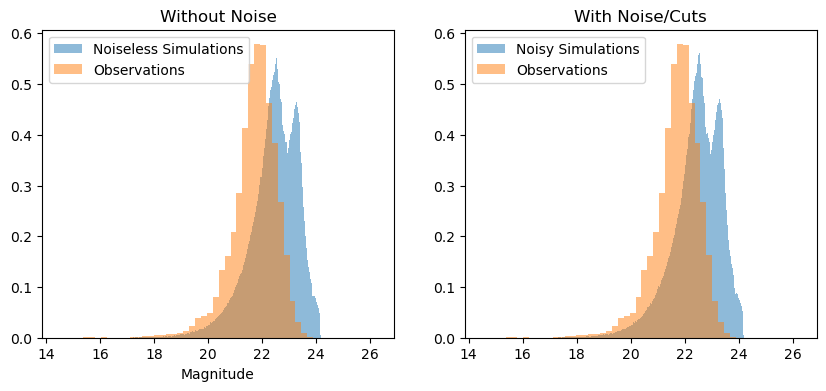

In [25]:
#overall magnitude distribution plot
label1 = 'Noiseless Simulations'
label2 = 'Observations'
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ax[0].hist(all_noise, bins=500, alpha=0.5, label=label1, density=True)
ax[0].hist(all_obs['col0'], bins=50, alpha=0.5, label=label2, density=True)
ax[0].set_title('Without Noise')
ax[0].set_xlabel('Magnitude')
ax[0].legend()


ax[1].hist(all_noise2, bins=500, alpha=0.5, label="Noisy Simulations", density=True)
ax[1].hist(all_obs['col0'], bins=50, alpha=0.5, label=label2, density=True)
ax[1].set_title('With Noise/Cuts')
ax[1].legend()

# ax[2].hist(rsims_magsnl[np.isfinite(rsims_magsnl)], bins=500, alpha=0.5, label=label1, density=True)
# ax[2].hist(all_rs['mag'], bins=50, alpha=0.5, label=label2, density=True)
# ax[2].set_title('R Magnitudes')
# ax[2].legend()

# fig.savefig("plots/mags.jpeg", dpi=1200)

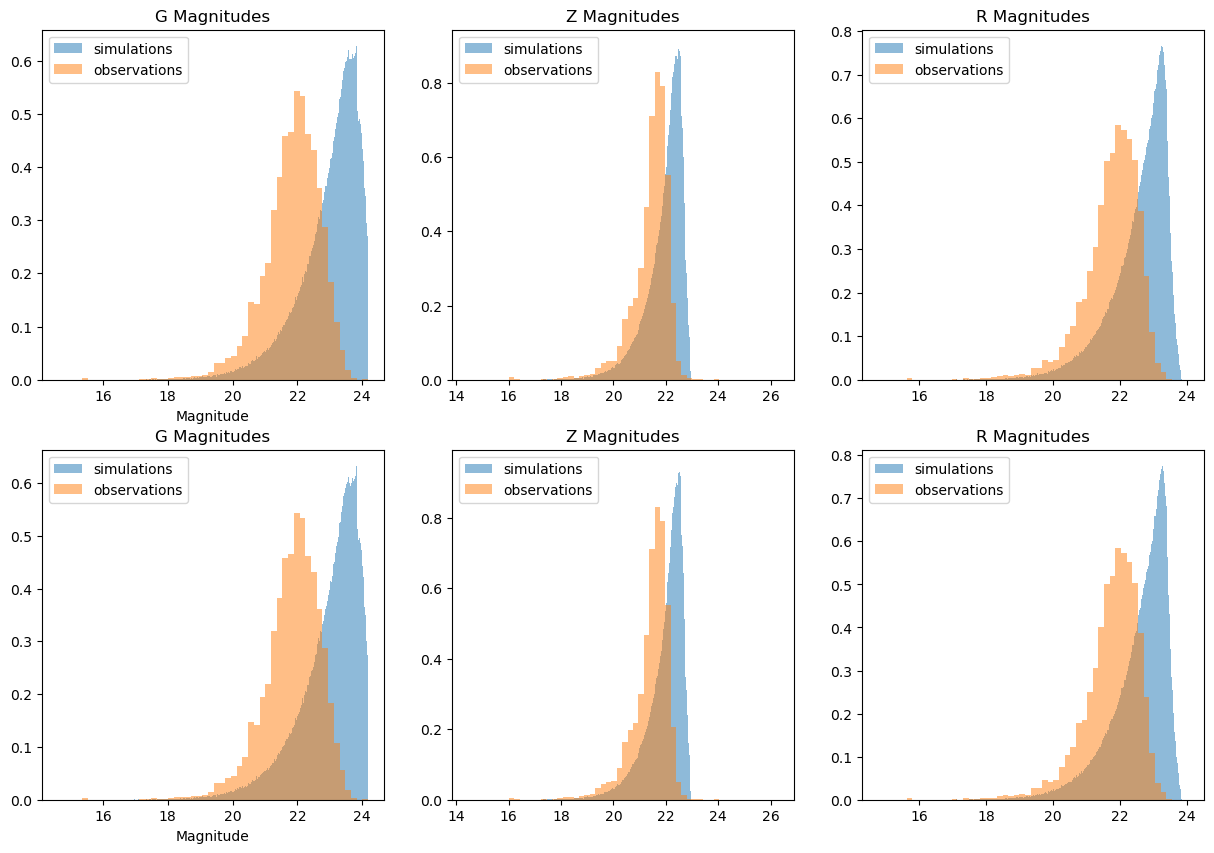

In [26]:
#by band magnitude distribution comparison between noisy without cuts and observations and noisy with cuts and observations
label1 = 'simulations'
label2 = 'observations'
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

ax[0][0].hist(gsims_mags, bins=500, alpha=0.5, label=label1, density=True)
ax[0][0].hist(all_gs['mag'], bins=50, alpha=0.5, label=label2, density=True)
ax[0][0].set_title('G Magnitudes')
ax[0][0].set_xlabel('Magnitude')
ax[0][0].legend()


ax[0][1].hist(zsims_mags, bins=500, alpha=0.5, label=label1, density=True)
ax[0][1].hist(all_zs['mag'], bins=50, alpha=0.5, label=label2, density=True)
ax[0][1].set_title('Z Magnitudes')
ax[0][1].legend()

ax[0][2].hist(rsims_mags, bins=500, alpha=0.5, label=label1, density=True)
ax[0][2].hist(all_rs['mag'], bins=50, alpha=0.5, label=label2, density=True)
ax[0][2].set_title('R Magnitudes')
ax[0][2].legend()

ax[1][0].hist(gsims_mags2, bins=500, alpha=0.5, label=label1, density=True)
ax[1][0].hist(all_gs['mag'], bins=50, alpha=0.5, label=label2, density=True)
ax[1][0].set_title('G Magnitudes')
ax[1][0].set_xlabel('Magnitude')
ax[1][0].legend()


ax[1][1].hist(zsims_mags2, bins=500, alpha=0.5, label=label1, density=True)
ax[1][1].hist(all_zs['mag'], bins=50, alpha=0.5, label=label2, density=True)
ax[1][1].set_title('Z Magnitudes')
ax[1][1].legend()

ax[1][2].hist(rsims_mags2, bins=500, alpha=0.5, label=label1, density=True)
ax[1][2].hist(all_rs['mag'], bins=50, alpha=0.5, label=label2, density=True)
ax[1][2].set_title('R Magnitudes')
ax[1][2].legend()

In [28]:
# get cadences for noisy simulations, use the progress bar. don't re-run if ran earlier in the notebook
sims_cadences_g = get_cadences(simspath, band='g', progressbar = True)
sims_cadences_r = get_cadences(simspath, band='r', progressbar = True)
sims_cadences_z = get_cadences(simspath, band='z', progressbar = True)

Progress: 100%|██████████| 19/19 [01:29<00:00,  4.71s/file, Processed=1424946]


In [29]:
# get cadences for simulations w noise and cuts, use the progress bar 
sims_cadences_g2 = get_cadences(simspath2, band='g', progressbar = True)
sims_cadences_r2 = get_cadences(simspath2, band='r', progressbar = True)
sims_cadences_z2 = get_cadences(simspath2, band='z', progressbar = True)

Progress: 100%|██████████| 19/19 [01:24<00:00,  4.47s/file, Processed=1137534]


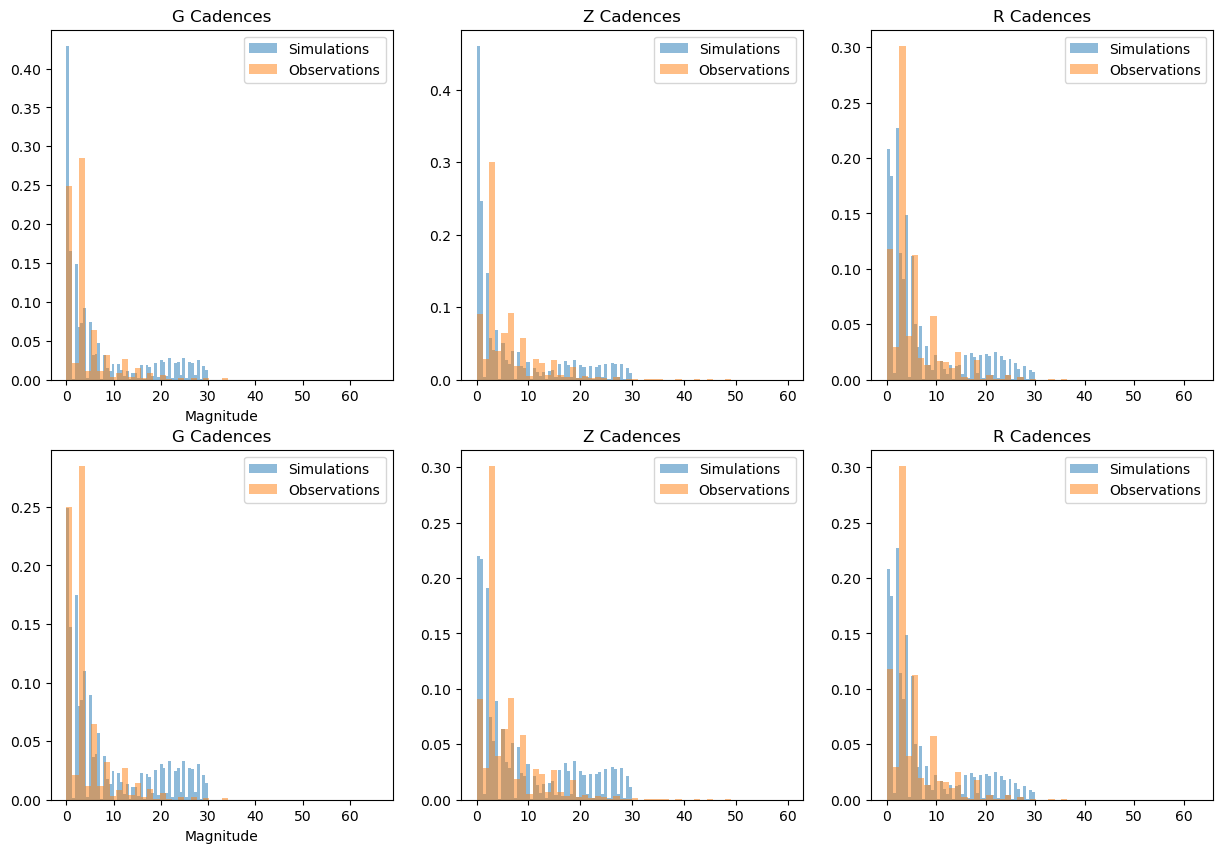

In [30]:
#cadence hist w simulations vs observations before and after cuts
label1 = 'Simulations'
label2 = 'Observations'
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

ax[0][0].hist(sims_cadences_g, bins=50, alpha=0.5, range=[0, 30], label=label1, density=True)
ax[0][0].hist(obs_cadences_g, bins=50, alpha=0.5, label=label2, density=True)
ax[0][0].set_title('G Cadences')
ax[0][0].set_xlabel('Magnitude')
ax[0][0].legend()


ax[0][1].hist(sims_cadences_z, bins=50, alpha=0.5, range=[0, 30], label=label1, density=True)
ax[0][1].hist(obs_cadences_z, bins=50, alpha=0.5, label=label2, density=True)
ax[0][1].set_title('Z Cadences')
ax[0][1].legend()

ax[0][2].hist(sims_cadences_r2, bins=50, alpha=0.5, range=[0, 30], label=label1, density=True)
ax[0][2].hist(obs_cadences_r, bins=50, alpha=0.5, label=label2, density=True)
ax[0][2].set_title('R Cadences')
ax[0][2].legend()

ax[1][0].hist(sims_cadences_g2, bins=50, alpha=0.5, range=[0, 30], label=label1, density=True)
ax[1][0].hist(obs_cadences_g, bins=50, alpha=0.5, label=label2, density=True)
ax[1][0].set_title('G Cadences')
ax[1][0].set_xlabel('Magnitude')
ax[1][0].legend()


ax[1][1].hist(sims_cadences_z2, bins=50, alpha=0.5, range=[0, 30], label=label1, density=True)
ax[1][1].hist(obs_cadences_z, bins=50, alpha=0.5, label=label2, density=True)
ax[1][1].set_title('Z Cadences')
ax[1][1].legend()

ax[1][2].hist(sims_cadences_r2, bins=50, alpha=0.5, range=[0, 30], label=label1, density=True)
ax[1][2].hist(obs_cadences_r, bins=50, alpha=0.5, label=label2, density=True)
ax[1][2].set_title('R Cadences')
ax[1][2].legend()